In [1]:
import pickle
with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))


fnumber = '01461'
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
ocean_time = dataset.variables['ocean_time'][:]


## Compute LNAM (L) and LOW 

In [3]:
x, y, uu, vv = lon_rho, lat_rho, U[:,:,0,0], V[:,:,0,0]

#----------------------------------------
# Calculation of eddy kinetic energy
ke = (uu**2 + vv**2) / 2

#----------------------------------------
# Calculation of finite spatial element
dx  = np.zeros_like(x)
dy  = np.zeros_like(x)
dux = np.zeros_like(x)
duy = np.zeros_like(x)
dvx = np.zeros_like(x)
dvy = np.zeros_like(x)

#----------------------------------------
# Spatial element in degrees if grid_ll==1 or in km otherwise
dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]

# if grid_ll: yes we are using earth coordinates in deg (lon,lat)
# Define constants
earth_radius = 6378.137  # km
# Kilometers (km) per degree of latitude
R = earth_radius * np.pi / 180  # ~111.320 km
# Calculate finite spatial element in km
dx = dx * R * np.cos(np.radians(y))
dy = dy * R

# Convert to meters
dx = dx * 1000  # m
dy = dy * 1000  # m

#----------------------------------------
# Compute speed element in m/s
dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]

#----------------------------------------
# Calculation of Okubo-Weiss criteria
sn = (dux / dx) - (dvy / dy)  # shear "cisaillement"
ss = (dvx / dx) + (duy / dy)  # strain "deformation"
om = (dvx / dx) - (duy / dy)  # vorticity "vorticité"

okubo = sn**2 + ss**2 - om**2  # in s^-2

#----------------------------------------
# Calculation of divergence
div = (dux / dx) + (dvy / dy)

#----------------------------------------
# Calculation of vorticity field (typically +/-10^-5 s^-1)
vorticity = om * np.sign(f)

#----------------------------------------
# Border is a parameter which prevents the constraints
# from being applied to points too close to the domain boundaries
# which would result in an index error
b = np.ones_like(x, dtype=int)
borders = np.max(b) + 1


# Initialization
L = np.zeros_like(uu)
LOW = np.full_like(uu, np.nan)

#----------------------------------------
# Calculate LNAM and LOW in all domain pixels
for i in range(borders, len(vv[:, 0]) - borders + 1):
    for j in range(borders, len(vv[0, :]) - borders + 1):

        if not np.isnan(vv[i, j]):

            # Calculate LOW
            OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
            LOW[i, j] = np.nanmean(OW)

            # Calculate LNAM
            xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
            ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]

            ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
            vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]

            # Local Normalized Angular Momentum
            # Use the middle of the square as center coordinate

            coordcentre = (xlocal.shape[0] - 1) // 2

            # if grid_ll:
            d_xcentre = (xlocal - xlocal[coordcentre, coordcentre]) * R * np.cos(np.radians(ylocal))
            d_ycentre = (ylocal - ylocal[coordcentre, coordcentre]) * R
            # else:
            #     d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
            #     d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])

            cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
            dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
            produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
            sumdp = np.sum(dot) + np.sum(produit)

            if sumdp != 0:
                L[i, j] = np.sum(cross) / sumdp * np.sign(f[i, j])
            else:
                L[i, j] = 0

# Replace NaNs with zeros
L[np.isnan(L)] = 0

LOW_cpy = LOW


(np.float64(147.07391730247966),
 np.float64(162.25363561382932),
 np.float64(-41.57627817158369),
 np.float64(-25.091913468410358))

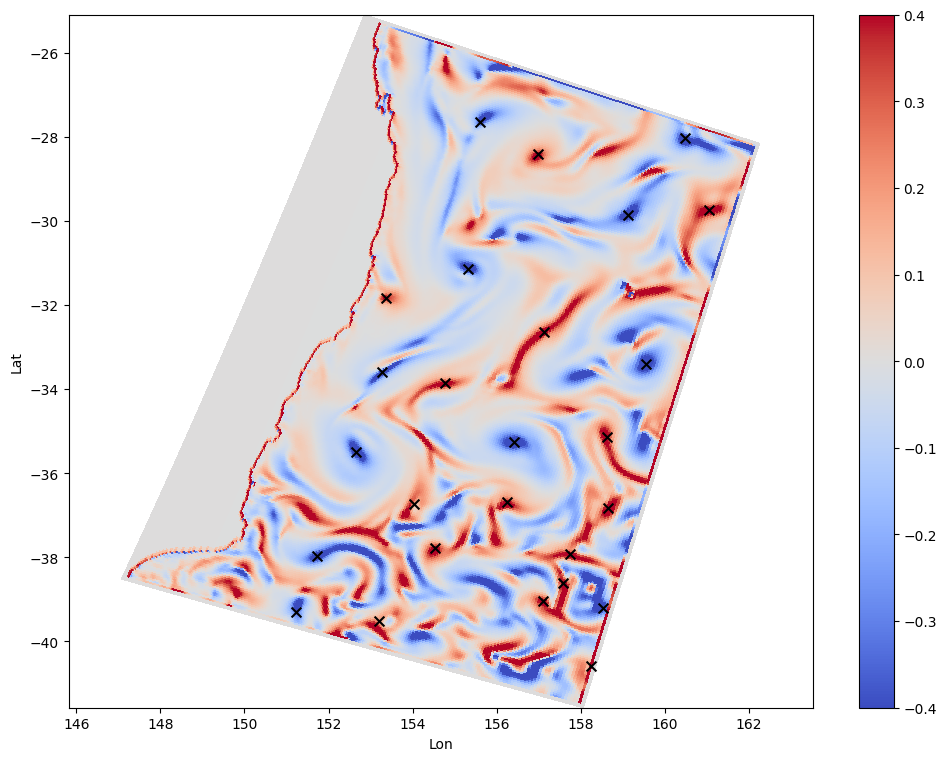

In [5]:
xdim, ydim = x.shape

xx = np.arange(xdim)
yy = np.arange(ydim)

xx, yy = np.meshgrid(xx,yy)

plt.figure(figsize=(12,9))

plt.pcolor(lon_rho[xx,yy], lat_rho[xx,yy], L[xx,yy], vmin=-.4,vmax=.4, cmap='coolwarm')
plt.colorbar()

daydic['Day1'].plot(ax=plt.gca(), kind='scatter', x='Lon', y='Lat', marker='x', color='k', s=50)
plt.axis('equal')
# plt.xlim([151, 154])
# plt.ylim([-37, -34])

## Eddy Centers

In [86]:
OW = LOW
LNAM = L
LOW = abs(LNAM);
LOW[(OW >= 0) | np.isnan(OW)] = 0

In [95]:
mask = LOW_cpy < 0
K = .7

fig = plt.figure()
CS = plt.contour(x, y, LOW, levels=[K])
plt.close(fig)

AttributeError: 'QuadContourSet' object has no attribute 'shape'

In [ ]:
from matplotlib.path import Path

def InPolygon(x, y, xv, yv):
    """Function to replicate the InPolygon behavior from MATLAB in Python."""
    points = np.vstack((x.flatten(), y.flatten())).T
    polygon = np.vstack((xv, yv)).T
    path = Path(polygon)
    return path.contains_points(points).reshape(x.shape)

# Initialize
j = 0  # first coordinates of the contour scan
k = 0  # first contour

centers0 = {'type': [], 'x': [], 'y': [], 'j': [], 'i': []}
MaxL = []

# Scan each LNAM contour
while j < CS.shape[1]:

    n = int(CS[1, j])  # number of coordinates for the contour(j)
    xv = CS[0, j+1:j+n+1]  # x values series for the contour(j) coordinates
    yv = CS[1, j+1:j+n+1]  # y values series for the contour(j) coordinates

    # Validate only bigger contours
    if n >= n_min:

        # Make a mask outside the contour
        in_polygon = InPolygon(x, y, xv, yv)
        maskin = np.copy(mask)
        maskin[~in_polygon] = 0
        maskin[in_polygon] = 1
        Lm = np.copy(LNAM)
        Lm[~in_polygon] = np.nan

        # L maximum value inside the contour(j)
        if np.any(mask * maskin > 0) and np.nanmax(np.abs(Lm)) != 0:

            LC = Lm[np.abs(Lm) == np.nanmax(np.abs(Lm))]

            # Save coordinates of the L maximum inside the contour(j)
            if mask[np.where(Lm == LC[0])[0][0]] == 1:

                xLmax = x[np.where(Lm == LC[0])[0][0]]
                yLmax = y[np.where(Lm == LC[0])[0][0]]

                if not grid_ll or (grid_ll and np.abs(yLmax) > lat_min):

                    if not np.any((centers0['x'] == xLmax) & (centers0['y'] == yLmax)):
                        centers0['type'].append(np.sign(LC[0]))
                        centers0['x'].append(xLmax)
                        centers0['y'].append(yLmax)
                        centers0['j'].append(np.where(Lm == LC[0])[0][0])
                        centers0['i'].append(np.where(Lm == LC[0])[1][0])
                        MaxL.append(LC[0])

                        # Increment the counter
                        k += 1  # next contour

    # Increment the counter
    j += n + 1  # series of coordinates of the next contour


## Calculating PSI (Streamfunction)

In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def sw_dist2(lat, lon):
    lat, lon = np.asarray(lat), np.asarray(lon)
    EARTH_RADIUS = 6378.137
    lat_rad, lon_rad = np.radians(lat), np.radians(lon)
    dlat, dlon = np.diff(lat_rad), np.diff(lon_rad)
    a = np.sin(dlat / 2)**2 + np.cos(lat_rad[:-1]) * np.cos(lat_rad[1:]) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

u, v = uu, vv
ci, cj = lon_rho.shape[0]//2, lat_rho.shape[1]//2 

#----------------------------------------
# Convert lon and lat into km distance matrices (can vary along i and j)
km_di = np.full((x.shape[0], x.shape[1] - 1), np.nan)
km_dj = np.full((y.shape[0] - 1, y.shape[1]), np.nan)

# Calculate km_di
for i in range(x.shape[0]):
    # if grid_ll:
    km_di[i, :] = sw_dist2(y[i, :], x[i, :])
    # else:
    #     km_di[i, :] = np.sqrt(np.diff(x[i, :])**2 + np.diff(y[i, :])**2)  # km

# Calculate km_dj
for i in range(x.shape[1]):
    # if grid_ll:
    km_dj[:, i] = sw_dist2(y[:, i], x[:, i])
    # else:
    #     km_dj[:, i] = np.sqrt(np.diff(x[:, i])**2 + np.diff(y[:, i])**2)  # km

#----------------------------------------
# Lengths for the 4 domains (NE, SE, NO, SO)
lx1 = u[cj:, :].shape[0]
lx2 = u[:cj, :].shape[0] + 1
ly1 = u[:, ci:].shape[1]
ly2 = u[:, :ci].shape[1] + 1

#----------------------------------------
# Adjust km_di and km_dj for trapezoidal integration starting at ci, cj
# (add first row/column of zeros)
di = np.hstack([km_di[:, :ci], np.zeros((lx1 + lx2 - 1, 1)), km_di[:, ci:]])
dj = np.vstack([km_dj[:cj, :], np.zeros((1, ly1 + ly2 - 1)), km_dj[cj:, :]])


In [7]:
from scipy.integrate import cumulative_trapezoid

#----------------------------------------
# Integrate first row of v along x
# (first term of the 4 parts of equations A1)
cx1 = cumulative_trapezoid(v[cj, ci:], initial=0) * di[cj, ci:]  # trapezoidal sum
cx2 = -cumulative_trapezoid(v[cj, ci::-1], initial=0) * di[cj, ci::-1]  # trapezoidal sum

# Integrate first column of u along y
# (first term of the 4 parts of equations A2)
cy1 = -cumulative_trapezoid(u[cj:, ci], initial=0) * dj[cj:, ci]
cy2 = cumulative_trapezoid(u[cj::-1, ci], initial=0) * dj[cj::-1, ci]

#----------------------------------------
# Expand the vectors into matrices to compute PSI
mcx11 = np.tile(cx1[np.newaxis, :], (lx1, 1))
mcx12 = np.tile(cx1[np.newaxis, :], (lx2, 1))
mcx21 = np.tile(cx2[np.newaxis, :], (lx1, 1))
mcx22 = np.tile(cx2[np.newaxis, :], (lx2, 1))
mcy11 = np.tile(cy1[:, np.newaxis], (1, ly1))
mcy12 = np.tile(cy1[:, np.newaxis], (1, ly2))
mcy21 = np.tile(cy2[:, np.newaxis], (1, ly1))
mcy22 = np.tile(cy2[:, np.newaxis], (1, ly2))


In [8]:
#----------------------------------------
# PSI from integrating v first and then u (4 parts of eq. A1)
psi_xy11 = mcx11 - cumulative_trapezoid(u[cj:, ci:], axis=0, initial=0) * dj[cj:, ci:]
psi_xy12 = mcx12 + cumulative_trapezoid(u[cj::-1, ci:], axis=0, initial=0) * dj[cj::-1, ci:]
psi_xy21 = mcx21 - cumulative_trapezoid(u[cj:, ci::-1], axis=0, initial=0) * dj[cj:, ci::-1]
psi_xy22 = mcx22 + cumulative_trapezoid(u[cj::-1, ci::-1], axis=0, initial=0) * dj[cj::-1, ci::-1]

# Concatenate 4 parts (NE, SE, NO, SO) (eq. A1)
psi_xy = np.block([
    [psi_xy22[::-1, ::-1], psi_xy12[::-1, :]],
    [psi_xy21[:, ::-1], psi_xy11]
])

In [9]:
#----------------------------------------
# PSI from integrating u first and then v (4 parts of eq. A2)
psi_yx11 = mcy11 + cumulative_trapezoid(v[cj:, ci:], axis=1, initial=0) * di[cj:, ci:]
psi_yx21 = mcy12 - cumulative_trapezoid(v[cj:, ci::-1], axis=1, initial=0) * di[cj:, ci::-1]
psi_yx12 = mcy21 + cumulative_trapezoid(v[cj::-1, ci:], axis=1, initial=0) * di[cj::-1, ci:]
psi_yx22 = mcy22 - cumulative_trapezoid(v[cj::-1, ci::-1], axis=1, initial=0) * di[cj::-1, ci::-1]

# Concatenate 4 parts (NE, SE, NO, SO) (eq. A2)
psi_yx = np.block([
    [psi_yx22[::-1, ::-1], psi_yx12[::-1, :]],
    [psi_yx21[:, ::-1], psi_yx11]
])

In [10]:
from scipy.ndimage import generic_filter

#----------------------------------------
# Compute PSI as average between the two (eq. A = (A1 + A2) / 2)
psi = (psi_xy + psi_yx) / 2 #* mask

# Enlarge PSI into land by 1 pixel -----------------------
# PSI in the first coastal pixel is an average of its 9 neighbors

#mask[np.isnan(mask)] = 0

def average_neighbors(arr):
    # Compute the mean of neighbors, excluding the central pixel
    center = arr[1, 1]
    if center == 0 and np.any(arr != 0):
        return np.nanmean(arr)
    else:
        return center

# # Apply the averaging function to pixels where mask is 0
# psi = generic_filter(
#     np.stack([psi, mask], axis=-1),
#     lambda x: average_neighbors(x[:, :, 0]),
#     size=(3, 3),
#     mode='constant',
#     cval=np.nan
# )

# Correct the mask to ensure that only land pixels are filled
# psi[mask == 1] = psi[mask == 1]


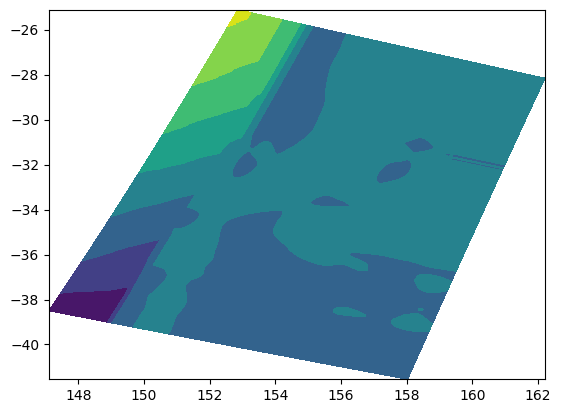

In [13]:
plt.contourf(lon_rho, lat_rho, psi[:-1,:-1])

In [38]:
def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

(np.float64(150.58364116381188),
 np.float64(154.68193839004124),
 np.float64(-37.223310717238974),
 np.float64(-33.76638760929333))

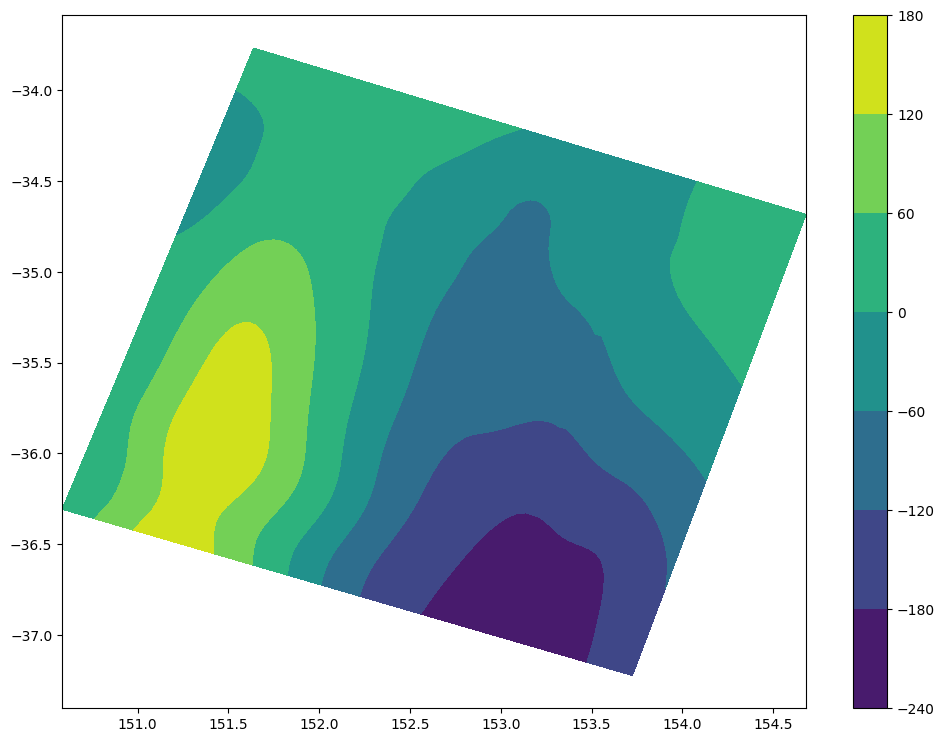

In [47]:
elon, elat = daydic['Day1'].loc['Eddy22'].Lon, daydic['Day1'].loc['Eddy22'].Lat
i_search, j_search = eddies_nearest_rho(elon, elat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, 300000)

xdim, ydim = x.shape

xx = np.arange(i_left,i_right)
yy = np.arange(j_down,j_up)

xx, yy = np.meshgrid(xx,yy)

plt.figure(figsize=(12,9))

plt.contourf(lon_rho[xx,yy], lat_rho[xx,yy], psi[xx,yy])
plt.colorbar()

# daydic['Day1'].plot(ax=plt.gca(), kind='scatter', x='Lon', y='Lat', marker='x', color='k', s=50)
plt.axis('equal')
# plt.xlim([151, 154])
# plt.ylim([-37, -34])

## Eddy Centers

In [85]:
LNAM = L


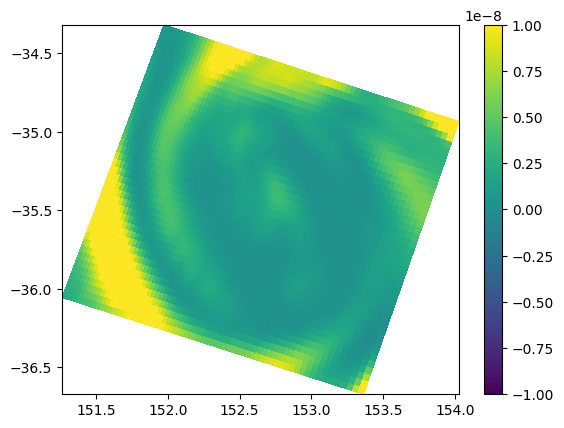

In [84]:
elon, elat = daydic['Day1'].loc['Eddy22'].Lon, daydic['Day1'].loc['Eddy22'].Lat
i_search, j_search = eddies_nearest_rho(elon, elat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, 200000)

plt.pcolor(lon_rho[i_left:i_right,j_down:j_up],lat_rho[i_left:i_right,j_down:j_up],LOW[i_left:i_right,j_down:j_up],vmin=-1e-8,vmax=1e-8)
plt.colorbar()

In [81]:
LOW_masked = np.where(okubo<0,okubo,np.nan)